# Regularisers

Torchbearer has a number of [built-in regularisers](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#regularisers) which can be added to any image problem with a simple callback. In the example we will quickly demonstrate each one and give an example of how they modify the image. 

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Torchbearer

First we install torchbearer if needed. 

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
!pip install -q /home/matt/PycharmProjects/PyTorch-bink/
import torchbearer
print(torchbearer.__version__)

0.4.0.dev


## Data

For simplicity and speed, this example will use MNIST. MNIST also has the advantage that it is usually quite easy to overfit on, and so if you want to run this example with a more powerful model and for a few more epochs then you should see be able to see the power of each regulariser. 

In [2]:
import torch
from torchvision import datasets, transforms
from torchbearer.cv_utils import DatasetValidationSplitter

transform = transforms.Compose([
                        transforms.ToTensor(),
                   ])
BATCH_SIZE = 128
dataset = datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

splitter = DatasetValidationSplitter(len(dataset), 0.1)
trainset = splitter.get_train_dataset(dataset)
valset = splitter.get_val_dataset(dataset)

traingen = torch.utils.data.DataLoader(trainset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
valgen = torch.utils.data.DataLoader(valset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
testgen = torch.utils.data.DataLoader(testset, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)


## Model

We take the same model as the [quickstart example](https://torchbearer.readthedocs.io/en/latest/examples/notebooks.html#general) and modify it to run on MNIST. This should run very quickly which will help us see the impact of the reguliarisers. 

In [3]:
import torch.nn as nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, stride=2, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, stride=2, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride=2, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.classifier = nn.Linear(64*2*2, 10)

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, 64*2*2)
        return self.classifier(x)


model = SimpleModel()

## Set of Regularisers

Torchbearer has the following built-in reguliarisers:
- **Cutout**: Randomly replaces an area of the image with a constant value
- **RandomErase**: Randomly replaces an area of the image with noise
- **Sample Pairing**: Averages two images without change to targets
- **MixUp**: Linearly combines two images and their labels

Here we create the callbacks for each of these in turn. 


In [4]:
from torchbearer.callbacks import Cutout, RandomErase, Mixup, SamplePairing

cutout = Cutout(n_holes=1, length=8, constant=1)
random_erase = RandomErase(n_holes=2, length=6)
mixup = Mixup()

# Do sample pairing for the first two epochs for demonstration. 
# We recommend using the policy from the paper (`policy=None`) for training purposes
pairing = SamplePairing(SamplePairing.default_policy(0, 2, 8, 2))

## Visualising

All of the regularisers that we are going to show are very visual. We would like to see how they modify the image so we create a MakeGrid callback form imaging to show the input data once every epoch. 

In [5]:
import torchbearer.callbacks.imaging as imag

make_grid = imag.MakeGrid(torchbearer.INPUT, num_images=8, nrow=8)
make_grid = make_grid.on_train().to_pyplot()

## Trial

Now lets create a number of trails and observe how each of the regularisers changes the results. 

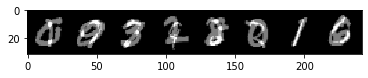

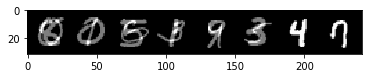

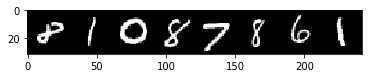

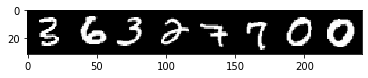

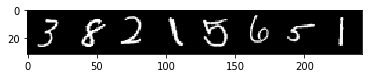

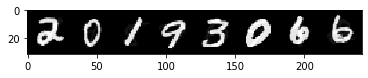

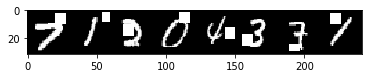

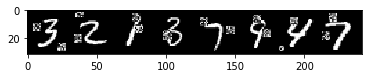

In [6]:
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss = nn.CrossEntropyLoss()

import torchbearer
from torchbearer import Trial


### Sample Pairing
model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [pairing, make_grid]
trial_sp = Trial(model, optimizer, loss, metrics=['loss', 'acc'], callbacks=callbacks).to(device)
trial_sp.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_sp = trial_sp.run(epochs=5, verbose=1)


# Only sample pairing changes the regularisation based on the epoch
# From now on we hack the make_grid callback to only print once per training through the only_if decorator
from torchbearer.callbacks import only_if
make_grid.on_step_training = only_if(lambda state: state[torchbearer.EPOCH] == 0)(make_grid.on_step_training)


### Mixup
model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [mixup, make_grid]
trial_mu = Trial(model, optimizer, Mixup.mixup_loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial_mu.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_mu = trial_mu.run(epochs=5, verbose=1)


### Cutout
model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [cutout, make_grid]
trial_co = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial_co.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_cutout = trial_co.run(epochs=5, verbose=1)


### Random Erase
model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = [random_erase, make_grid]
trial_re = Trial(model, optimizer, loss, metrics=['acc', 'loss'], callbacks=callbacks).to(device)
trial_re.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_erase = trial_re.run(epochs=5, verbose=1)


### Baseline - no regulariser
model = SimpleModel()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

callbacks = []
trial_base = Trial(model, optimizer, loss, metrics=['loss', 'acc'], callbacks=callbacks).to(device)
trial_base.with_generators(train_generator=traingen, val_generator=valgen, test_generator=testgen)
history_base = trial_base.run(epochs=5, verbose=1)




## Results

We show some results for these models, quoting the accuracies on validation and test.

In [7]:
print('Final val acc for baseline: {}'.format(history_base[-1]['val_acc']))

print('Final val acc for cutout: {}'.format(history_cutout[-1]['val_acc']))
print('Final val acc for random erase: {}'.format(history_erase[-1]['val_acc']))
print('Final val acc for mixup: {}'.format(history_mu[-1]['val_mixup_acc']))
print('Final val acc for sample pairing: {}'.format(history_sp[-1]['val_acc']))

print('\n')
print('Final test acc for baseline: {}'.format(trial_base.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)['test_acc']))
print('Final test acc for cutout: {}'.format(trial_co.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)['test_acc']))
print('Final test acc for random erase: {}'.format(trial_re.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)['test_acc']))
print('Final test acc for mixup: {}'.format(trial_mu.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)['test_mixup_acc']))
print('Final test acc for sample pairing: {}'.format(trial_sp.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)['test_acc']))


Final val acc for baseline: 0.984833300113678
Final val acc for cutout: 0.9836666584014893
Final val acc for random erase: 0.984833300113678
Final val acc for mixup: 0.9776666760444641
Final val acc for sample pairing: 0.9825000166893005


Final test acc for baseline: 0.9878000020980835
Final test acc for cutout: 0.9870999455451965
Final test acc for random erase: 0.9886999726295471
Final test acc for mixup: 0.9812999963760376
Final test acc for sample pairing: 0.9850999712944031


We now plot the validation accuracies over time. In reality it would be better to log to tensorboard, visdom or live loss plot, but for this example we just use pyplot. From this small amount of training we cannot draw many conclusions, but hopefully you'll see that early on the regularised models perform slightly worse than the baseline with 

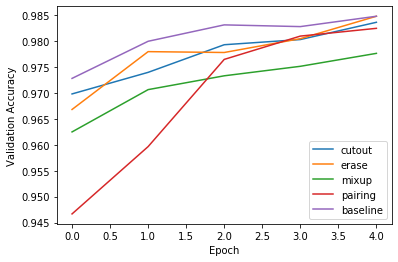

In [9]:
import matplotlib.pyplot as plt

cutout_accs = [history_cutout[i]['val_acc'] for i in range(len(history_cutout))]
erase_accs = [history_erase[i]['val_acc'] for i in range(len(history_erase))]
mixup_accs = [history_mu[i]['val_mixup_acc'] for i in range(len(history_mu))]
pairing_accs = [history_sp[i]['val_acc'] for i in range(len(history_sp))]
baseline_accs = [history_base[i]['val_acc'] for i in range(len(history_base))]

plt.plot(cutout_accs, label='cutout')
plt.plot(erase_accs, label='erase')
plt.plot(mixup_accs, label='mixup')
plt.plot(pairing_accs, label='pairing')
plt.plot(baseline_accs, label='baseline')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.show()